# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Cargamos los datos

In [2]:
df = pd.read_csv('data/df_furniture.csv', parse_dates=['Month'])

In [3]:
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     326 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


In [5]:
df.rename(columns={'Month' : 'date'}, inplace=True)

In [6]:
df[df['date'].isna()]

,date,furniture_price_adjusted
15,NaT,2457.704334
21,NaT,2715.938414
39,NaT,2857.008678
40,NaT,3086.648631
60,NaT,3298.628987


## 2. Tratar la fecha como texto y parsear

In [7]:
df['date'] = df['date'].interpolate(method='linear')

In [8]:
df['date'] = pd.date_range(df['date'].min(), df['date'].max(), freq='MS')

In [9]:
df['fecha_str'] = df['date'].astype(str)

In [10]:
df[['year', 'month', 'day']] = df['fecha_str'].str.split('-', expand=True)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

In [11]:
df['new_date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.head()

,date,furniture_price_adjusted,fecha_str,year,month,day,new_date
0,1992-01-01,2073.432724,1992-01-01,1992,1,1,1992-01-01
1,1992-02-01,2114.485812,1992-02-01,1992,2,1,1992-02-01
2,1992-03-01,2260.570891,1992-03-01,1992,3,1,1992-03-01
3,1992-04-01,2255.103236,1992-04-01,1992,4,1,1992-04-01
4,1992-05-01,2331.414618,1992-05-01,1992,5,1,1992-05-01


## 3. ¿De qué fecha a qué fecha va el histórico?

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
print('La fecha mínima es ', df['date'].min(), 'y la máxima ', df['date'].max())

La fecha mínima es  1992-01-01 00:00:00 y la máxima  2019-07-01 00:00:00


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

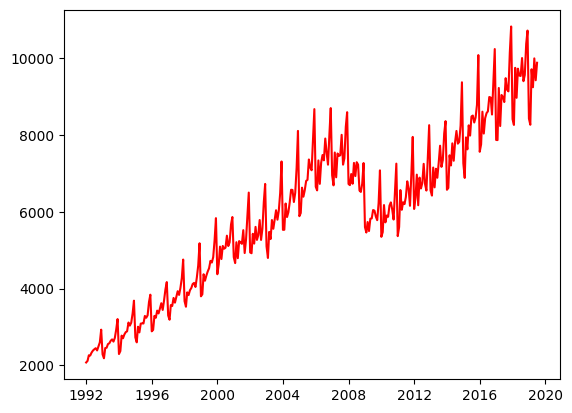

In [14]:
plt.plot(df['date'],df['furniture_price_adjusted'], '-r');

La serie tiene una tendencia ascendente exponencial y presenta estacionalidad

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [15]:
#1
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(df['furniture_price_adjusted'].values)
result[1]

np.float64(0.7035529748089981)

El test supera 0.05 por lo tanto no es estacionaria

In [16]:
#2
print(df['furniture_price_adjusted'].iloc[:20].agg(['mean','median']))
print(df['furniture_price_adjusted'].iloc[80:150].agg(['mean','median']))
print(df['furniture_price_adjusted'].iloc[230:300].agg(['mean','median']))

mean      2425.158806
median    2431.332053
Name: furniture_price_adjusted, dtype: float64
mean      5267.793151
median    5223.275791
Name: furniture_price_adjusted, dtype: float64
mean      7561.439657
median    7449.502329
Name: furniture_price_adjusted, dtype: float64


In [17]:
df[(round(len(df)/4)):166].describe()

,date,furniture_price_adjusted,year,month,day,new_date
count,83,83.000000,83.000000,83.000000,83.0,83
mean,2002-05-01 22:15:54.216867456,5586.420706,2001.879518,6.445783,1.0,2002-05-01 22:15:54.216867456
min,1998-12-01 00:00:00,3798.332299,1998.000000,1.000000,1.0,1998-12-01 00:00:00
25%,2000-08-16 12:00:00,5051.786181,2000.000000,3.500000,1.0,2000-08-16 12:00:00
50%,2002-05-01 00:00:00,5477.943949,2002.000000,6.000000,1.0,2002-05-01 00:00:00
75%,2004-01-16 12:00:00,6129.736767,2004.000000,9.000000,1.0,2004-01-16 12:00:00
max,2005-10-01 00:00:00,8110.153770,2005.000000,12.000000,1.0,2005-10-01 00:00:00
std,NaN,856.515544,2.014566,3.457946,0.0,NaN


In [18]:
df[(round(len(df)/4)):249].describe()

,date,furniture_price_adjusted,year,month,day,new_date
count,166,166.000000,166.000000,166.000000,166.0,166
mean,2005-10-16 01:35:25.301204864,6158.508118,2005.337349,6.451807,1.0,2005-10-16 01:35:25.301204864
min,1998-12-01 00:00:00,3798.332299,1998.000000,1.000000,1.0,1998-12-01 00:00:00
25%,2002-05-08 18:00:00,5402.041002,2002.000000,3.250000,1.0,2002-05-08 18:00:00
50%,2005-10-16 12:00:00,6116.772258,2005.000000,6.000000,1.0,2005-10-16 12:00:00
75%,2009-03-24 06:00:00,6826.254192,2009.000000,9.000000,1.0,2009-03-24 06:00:00
max,2012-09-01 00:00:00,8705.820949,2012.000000,12.000000,1.0,2012-09-01 00:00:00
std,NaN,1005.357157,4.011429,3.454566,0.0,NaN


In [19]:
df[(round(len(df)/4))::].describe()

,date,furniture_price_adjusted,year,month,day,new_date
count,248,248.000000,248.000000,248.000000,248.0,248
mean,2009-03-17 00:11:36.774193664,6911.541574,2008.754032,6.451613,1.0,2009-03-17 00:11:36.774193664
min,1998-12-01 00:00:00,3798.332299,1998.000000,1.000000,1.0,1998-12-01 00:00:00
25%,2004-01-24 06:00:00,5796.329457,2004.000000,3.000000,1.0,2004-01-24 06:00:00
50%,2009-03-16 12:00:00,6729.457646,2009.000000,6.000000,1.0,2009-03-16 12:00:00
75%,2014-05-08 18:00:00,7919.530397,2014.000000,9.000000,1.0,2014-05-08 18:00:00
max,2019-07-01 00:00:00,10833.501852,2019.000000,12.000000,1.0,2019-07-01 00:00:00
std,NaN,1485.769186,5.984459,3.462593,0.0,NaN


## 6. ¿Conoces algún método para representar mejor la tendencia?

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

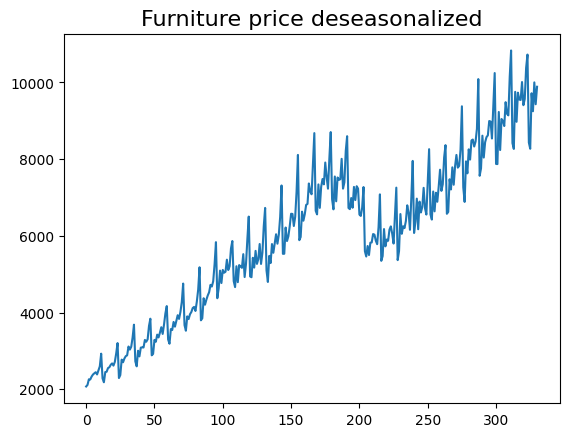

In [21]:
#1
result_multi = seasonal_decompose(df['furniture_price_adjusted'], model='multiplicative', period=12)

# Deseasonalize
deseasonalized = df.furniture_price_adjusted.values - result_multi.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Furniture price deseasonalized', fontsize=16);

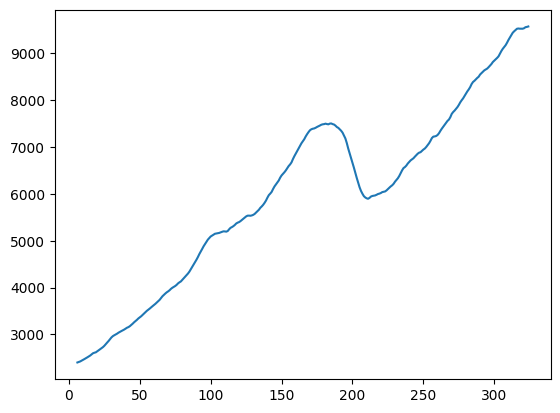

In [22]:
#3
plt.plot(result_multi.trend);

In [23]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [24]:
#2
df_ma = df.furniture_price_adjusted.rolling(3).mean()

In [25]:
df_loess_5 = pd.DataFrame(lowess(df.furniture_price_adjusted, np.arange(len(df.furniture_price_adjusted)), frac=0.05)[:, 1], index=df.index, columns=['furniture_price_adjusted'])
df_loess_15 = pd.DataFrame(lowess(df.furniture_price_adjusted, np.arange(len(df.furniture_price_adjusted)), frac=0.15)[:, 1], index=df.index, columns=['furniture_price_adjusted'])

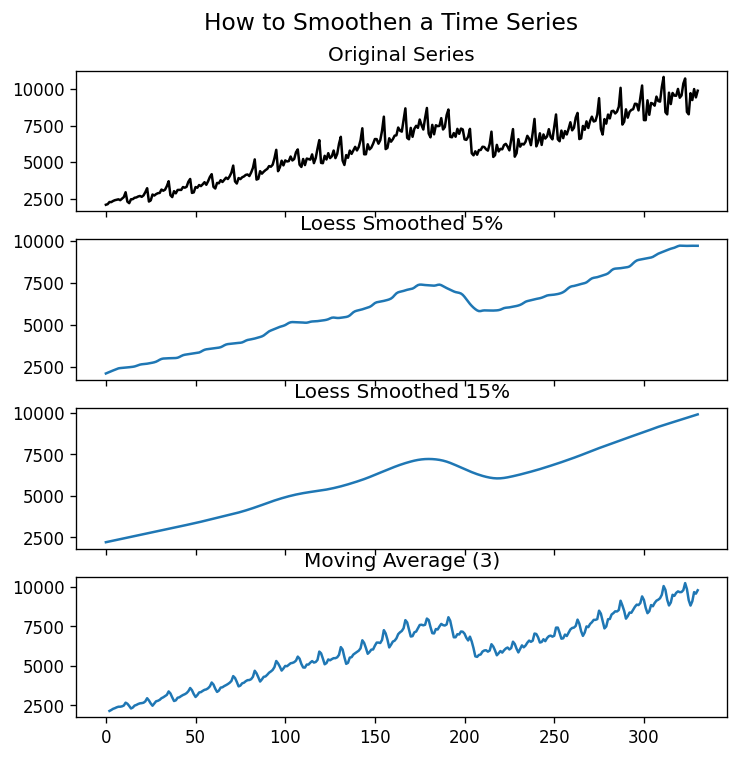

In [26]:
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['furniture_price_adjusted'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['furniture_price_adjusted'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['furniture_price_adjusted'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show();

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

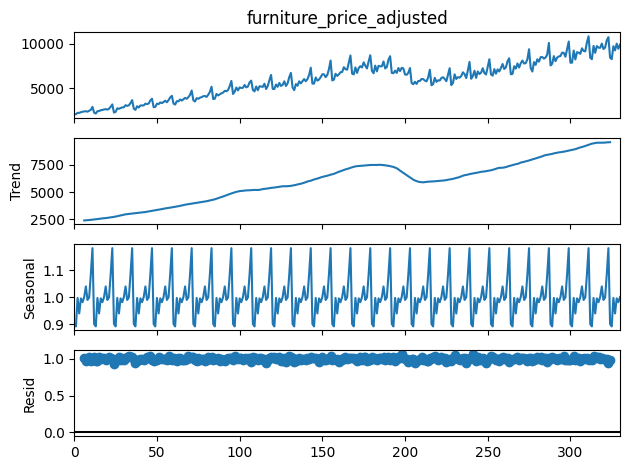

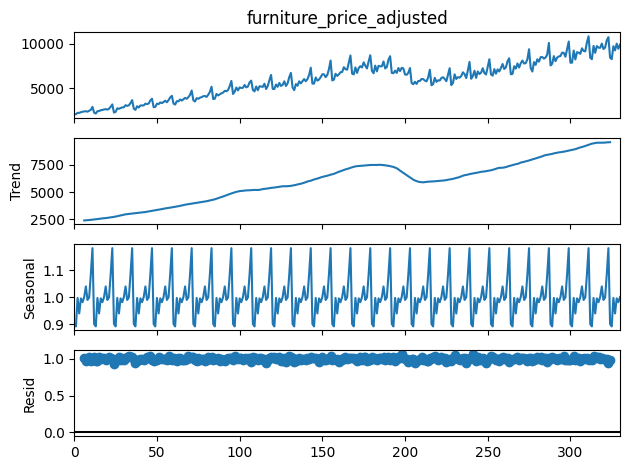

In [27]:
result_multi.plot()

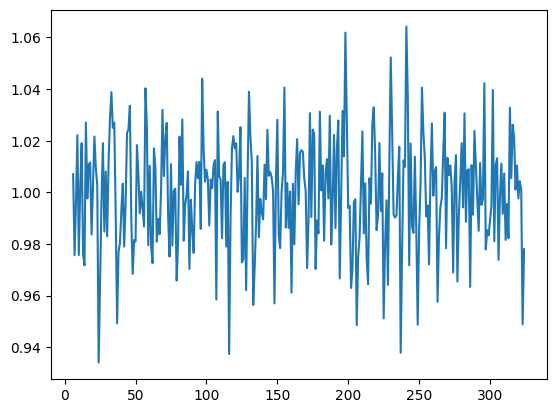

In [28]:
plt.plot(result_multi.resid);

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

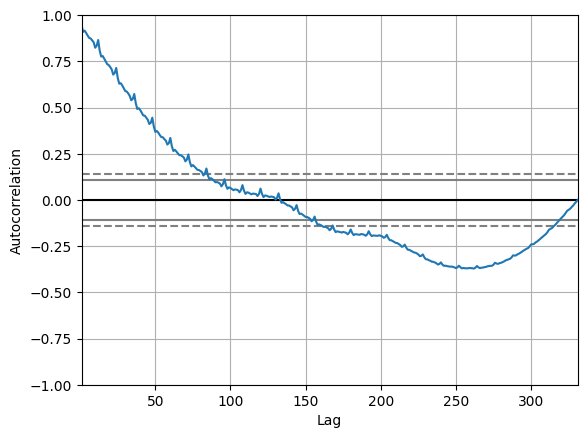

In [29]:
#1
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.furniture_price_adjusted.values);

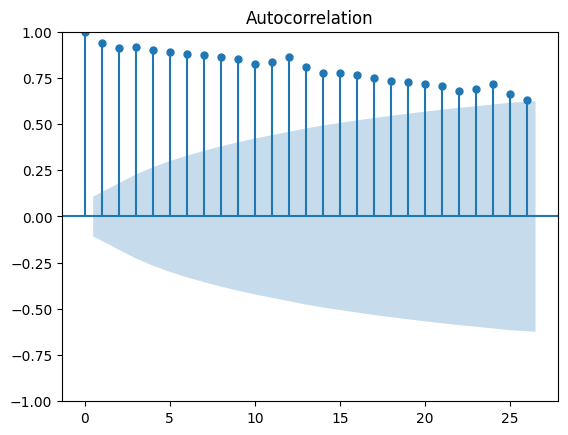

In [30]:
#2
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['furniture_price_adjusted']);

## 9. ¿Qué dependencia tiene cada instante de sus últimos 5 lags? Demuéstralo mediante una matriz de correlación.

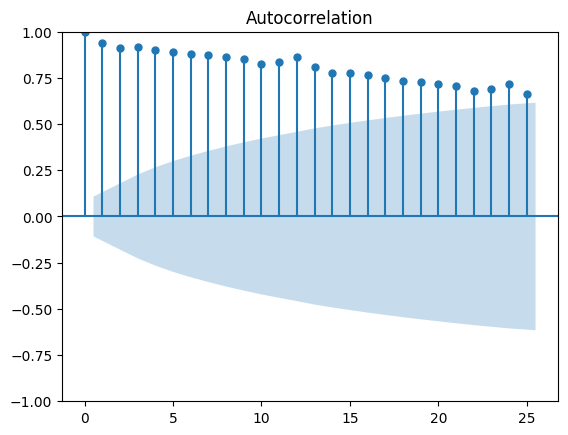

In [31]:
plot_acf(df['furniture_price_adjusted'], lags=25);

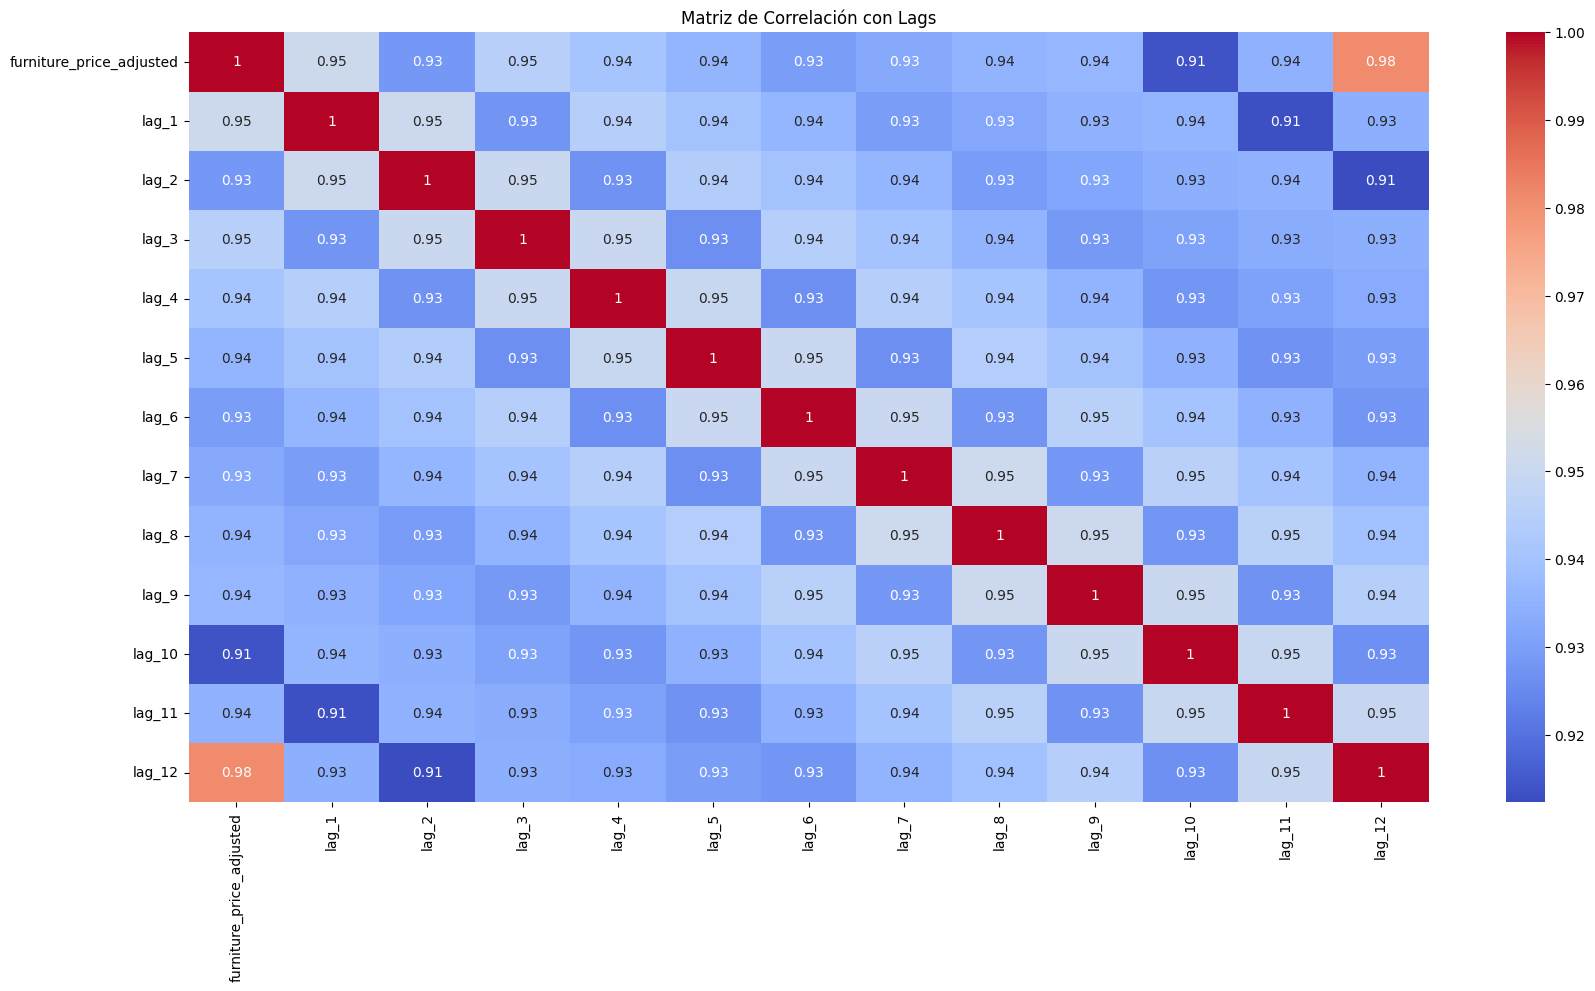

In [32]:
#2
# Creamos columnas para los últimos 5 lags
for lag in range(1, 13):
    df[f'lag_{lag}'] = df['furniture_price_adjusted'].shift(lag)

# Calculamos la matriz de correlación
correlation_matrix = df[['furniture_price_adjusted'] + [f'lag_{lag}' for lag in range(1, 13)]].corr()

# Visualizamos la matriz de correlación
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación con Lags')
plt.show()

## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

El patrón se cumple cada 12 instantes

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

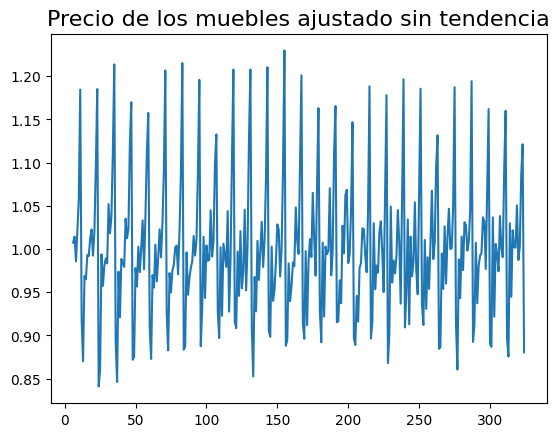

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_multi = seasonal_decompose(df['furniture_price_adjusted'], model='multiplicative', period=12)
detrended = df.furniture_price_adjusted.values / result_multi.trend
plt.plot(detrended)
plt.title('Precio de los muebles ajustado sin tendencia', fontsize=16);

0.025288379295709325


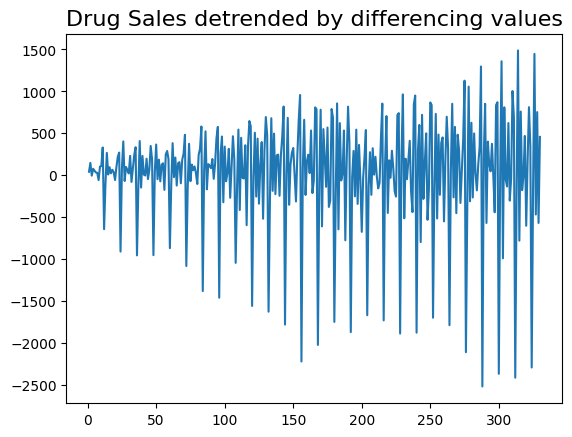

In [34]:
#2
plt.plot(df.furniture_price_adjusted.diff())
print(adfuller(df.furniture_price_adjusted.diff().dropna().values)[1])
plt.title('Drug Sales detrended by differencing values', fontsize=16);